# CMIP6 Temperature Changes

Description: The goal is to build a data structure of temperature changes across the model ensemble. We will build one for global time-series and one for spatially-resolved trends.

# Preprocessing Data

In [75]:
#imports
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

In [76]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [77]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [78]:
df_tas_hist=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")

#  assemble a set of models (source_id) for each experiment + variable combination
models_tas_hist  =set(df_tas_hist.source_id)    # all models that have temperature in the historical simulations
models_tas_ssp585=set(df_tas_ssp585.source_id)  # all models that have temperature in the ssp585     simulations

# let's only keep the models that have all the runs (the intersection of the set)
source_set = set.intersection(models_tas_hist, models_tas_ssp585)
source_list=list(source_set)
print(len(models_tas_hist))
print(len(models_tas_ssp585))

55
35


In [79]:
source_list

['E3SM-1-1',
 'INM-CM4-8',
 'IITM-ESM',
 'GFDL-ESM4',
 'NESM3',
 'INM-CM5-0',
 'EC-Earth3-Veg',
 'FGOALS-f3-L',
 'EC-Earth3',
 'ACCESS-ESM1-5',
 'IPSL-CM6A-LR',
 'BCC-CSM2-MR',
 'EC-Earth3-CC',
 'GFDL-CM4',
 'CAMS-CSM1-0',
 'CIESM',
 'MIROC6',
 'CMCC-CM2-SR5',
 'FIO-ESM-2-0',
 'CAS-ESM2-0',
 'TaiESM1',
 'EC-Earth3-Veg-LR',
 'CMCC-ESM2',
 'MRI-ESM2-0',
 'AWI-CM-1-1-MR',
 'KACE-1-0-G',
 'MPI-ESM1-2-HR',
 'ACCESS-CM2',
 'MPI-ESM1-2-LR',
 'NorESM2-LM',
 'NorESM2-MM',
 'CESM2-WACCM',
 'CanESM5',
 'FGOALS-g3',
 'KIOST-ESM']

In [80]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

### 1.1 Loading One Model (CanESM5)

In [86]:
#load one model
df_tas_hist_canesm5=df.query  ("activity_id=='CMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585_canesm5=df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")
df_tas_hist_canesm5
df_tas_ssp585_canesm5

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
94452,ScenarioMIP,CCCma,CanESM5,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429


In [87]:
ds_hist_tas_canesm5 = load_zarr_dset(df_tas_hist_canesm5)
ds_ssp585_tas_canesm5 = load_zarr_dset(df_tas_ssp585_canesm5)
#finding the historical/predicted mean using xarray dataset
ds_hist_tas_canesm5_mean = ds_hist_tas_canesm5.mean('time')
ds_ssp585_tas_canesm5_mean = ds_ssp585_tas_canesm5.mean('time')
ds_hist_tas_canesm5_mean

<xarray.Dataset>
Dimensions:   (lat: 64, bnds: 2, lon: 128)
Coordinates:
    height    float64 ...
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas       (lat, lon) float32 dask.array<chunksize=(64, 128), meta=np.ndarray>

In [92]:
#load the temperature data
tas_hist_canesm5 = ds_hist_tas_canesm5.tas
tas_ssp585_canesm5 = ds_ssp585_tas_canesm5.tas
#find the weights of the area of the grid cells
weights_1_canesm5 = np.cos(np.deg2rad(tas_hist_canesm5.lat))
weights_2_canesm5 = np.cos(np.deg2rad(tas_ssp585_canesm5.lat))
#mean of the weighted historical and predicted

ds_hist_tas_canesm5_w_mean = tas_hist_canesm5.weighted(weights_1_canesm5).mean(dim = ('lon', 'lat'))
ds_ssp585_tas_canesm5_w_mean = tas_ssp585_canesm5.weighted(weights_2_canesm5).mean(dim = ('lon', 'lat'))
ds_hist_tas_canesm5_w_mean
ds_ssp585_tas_canesm5_w_mean
ds_tas_canesm5_merged = xr.merge([ds_hist_tas_canesm5_w_mean, ds_ssp585_tas_canesm5_w_mean], compat = 'override')
ds_tas_canesm5_merged

<xarray.Dataset>
Dimensions:  (time: 5412)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2300-12-16 12:00:00
    height   float64 2.0
Data variables:
    tas      (time) float64 dask.array<chunksize=(600,), meta=np.ndarray>

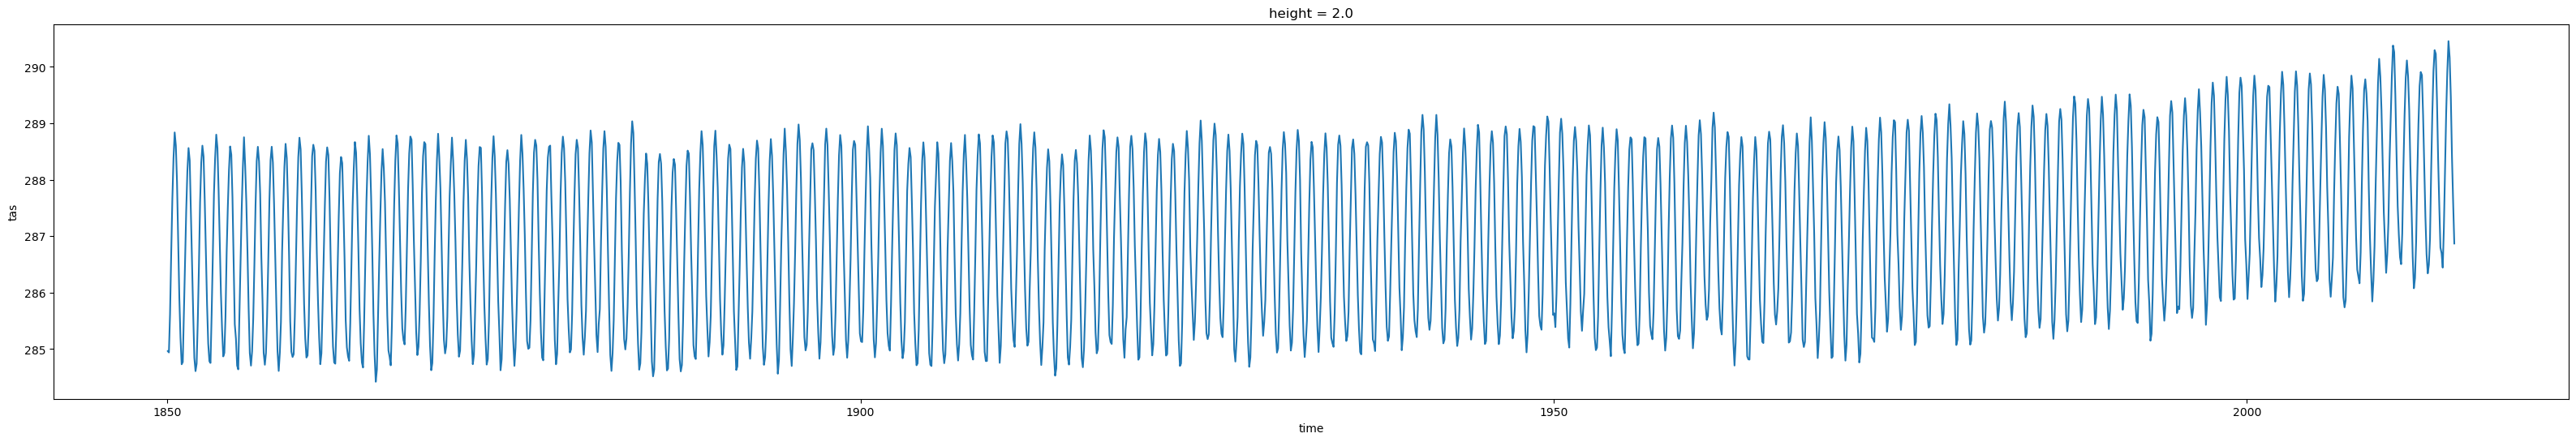

In [118]:
#plot time-series of global temperatures
fig, ax = plt.subplots(figsize = (40,6))
ds_tas_canesm5_merged.tas.plot(ax=ax)

### 1.2 Loading Multiple Models

In [124]:
#GCM picked out
gcm_list = ['E3SM-1-1',
 'INM-CM4-8',
 'IITM-ESM',
 'GFDL-ESM4',
 'NESM3']
gcm_5_models = df[(df['source_id'] == 'E3SM-1-1') | (df['source_id'] == 'INM-CM4-8') | (df['source_id'] == 'IITM-ESM') | 
(df['source_id']=='GFDL-ESM4')| (df['source_id'] == 'NESM3')]

In [83]:
#load multiple models
ds_list = list()
for source in gcm_5_models:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id==@source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id==@source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #load the temperature data
    tas_hist = ds_hist_tas.tas.sel(time=slice(
    tas_ssp585 = ds_ssp585_tas.tas
    #compute global means with weights
    weights_1_canesm5 = np.cos(np.deg2rad(tas_hist.lat))
    weights_2_canesm5 = np.cos(np.deg2rad(tas_ssp585.lat))
    ds_hist_tas_w_mean = tas_hist.weighted(weights_1_canesm5).mean(dim = ('lon', 'lat'))
    ds_ssp585_tas_w_mean = tas_ssp585.weighted(weights_2_canesm5).mean(dim = ('lon', 'lat'))
    ds_tas_merged = xr.merge([ds_hist_tas_w_mean, ds_ssp585_tas_w_mean], compat = 'override')
    ds_tas_merged

TypeError: objects must be an iterable containing only Dataset(s), DataArray(s), and dictionaries.